# Dyna-Q

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import HTML
from celluloid import Camera
%matplotlib notebook
np.random.seed(100)

In [2]:
actions = np.array([[-1,  0],
                    [ 0, -1],
                    [ 1,  0],
                    [ 0,  1]], dtype=int)
rt = 0
up = 1
lf = 2
dn = 3

grid = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1],
                 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
                 [1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
                 [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1],
                 [1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1],
                 [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1],
                 [1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1],
                 [1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
                 [1, 0, 1, 1, 1, 1, 1, 1, 0, 4, 1],
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                 [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int)
path = 0
wall = 1
strt = 2
goal = 3
objt = 4

symbol_rewards = np.array([0., -1., 0., 10., 3.])
out_reward = -1.

symbol_terminal = np.array([False, False, False, True, False], dtype=bool)

In [3]:
episode_grid = None

def gridworld_init():
    global episode_grid
    episode_grid = grid
    return np.concatenate(np.where(episode_grid == strt))

def gridworld_step(s, a):
    global episode_grid
    sprime = s + actions[a]
#    print("si: " + str(sprime))
    if np.any(sprime < 0) or np.any(sprime >= episode_grid.shape):
        r = out_reward
        sprime = s
    else:
        r = symbol_rewards[episode_grid[tuple(sprime.tolist())]]
    if episode_grid[tuple(sprime.tolist())] == wall:
        sprime = s
    elif episode_grid[tuple(sprime.tolist())] == objt:
        episode_grid[tuple(sprime.tolist())] = path
    return (sprime, r)

def gridworld_is_terminal(s):
    return symbol_terminal[episode_grid[s[0], s[1]]]

In [4]:
cmap = cm.RdBu
cmap.set_bad('black', 1.)

vis_filter = np.array([1., np.nan, 1., 1., 1.])[grid]

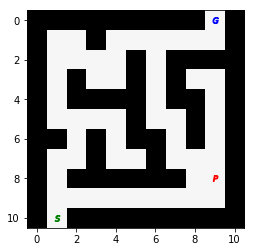

In [5]:
vis_map = 0. * vis_filter
masked_array = np.ma.array(vis_map, mask=np.isnan(vis_map))

fig, ax = plt.subplots(1, 1)

ax.imshow(masked_array, cmap=cmap, vmin=-40., vmax=40.)

ax.axis('off')

start_pos = (np.concatenate(np.where(grid == strt)))
start_glyph = plt.scatter(start_pos[1], start_pos[0], marker="$S$", color='green')
goal_pos = (np.concatenate(np.where(grid == goal)))
goal_glyph = plt.scatter(goal_pos[1], goal_pos[0], marker="$G$", color='blue')
pizza_pos = (np.concatenate(np.where(grid == objt)))
pizza_glyph = plt.scatter(pizza_pos[1], pizza_pos[0], marker="$P$", color='red')

plt.show()

In [6]:
eps = 0.1
alpha = 0.1
gamma = 0.9

In [7]:
Q = np.zeros((grid.shape[0], grid.shape[1], actions.shape[0]))
MS = np.zeros((grid.shape[0], grid.shape[1]), dtype=bool)
MSA = np.zeros((grid.shape[0], grid.shape[1], actions.shape[0]), dtype=bool)
MSp = np.zeros((grid.shape[0], grid.shape[1], actions.shape[0], 2), dtype=int)
MR = np.zeros((grid.shape[0], grid.shape[1], actions.shape[0]))
Mus = 10

def randargmax(vec):
    return np.random.choice(np.where(vec == np.max(vec))[0])

def Qrow(s):
    return Q[s[0], s[1], :]

def epsilon_greedy(s, epsilon):
    return randargmax(Qrow(s)) if np.random.random() > epsilon else np.random.randint(Qrow(s).shape[0])

def V(s):
    return np.max(Qrow(s))

def qlearning_episode(record=False, max_steps=100):
    global Q, MS, MSA, MSp, MR
    step = 0
    s = gridworld_init()
    if record and step < max_steps:
        trace_Q = [Q.copy()]
        trace_s = [s]
    else:
        trace_Q = []
        trace_s = []
    trace_a = []
    while not gridworld_is_terminal(s):
        step += 1
        MS[s[0], s[1]] = True
        a = epsilon_greedy(s, eps)
        MSA[s[0], s[1], a] = True
#        print("s: " + str(s) + " a: " + str(a))
        (sprime, r) = gridworld_step(s, a)
        MSp[s[0], s[1], a, :] = sprime
        MR[s[0], s[1], a] = r
#        print("s': " + str(sprime) + " r: " + str(r))
#        print("Q[s, a]: " + str(Q[s[0], s[1], a]))
        td_error = r - Q[s[0], s[1], a]
        if not gridworld_is_terminal(sprime):
            td_error += gamma * V(sprime)
#        print("TD error': " + str(td_error))
        Q[s[0], s[1], a] += alpha * td_error
#        print("Q[s, :]: " + str(Q[s[0], s[1], :]))
        MSI = np.where(MS)
        num_MS = MSI[0].shape[0]
        for i in range(Mus):
            si = np.random.randint(num_MS)
            s_m = np.array([MSI[0][si], MSI[1][si]])
            MsAI = np.where(MSA[s_m[0], s_m[1], :])
            num_MsA = MsAI[0].shape[0]
            ai = np.random.randint(num_MsA)
            a_m = MsAI[0][ai]
            sprime_m = MSp[s_m[0], s_m[1], a_m, :]
            r_m = MR[s_m[0], s_m[1], a_m]
            td_error_m = r_m - Q[s_m[0], s_m[1], a_m]
            if not gridworld_is_terminal(sprime_m):
                td_error_m += gamma * V(sprime_m)
            Q[s_m[0], s_m[1], a_m] += alpha * td_error_m
        s = sprime
        if record and step < max_steps:
            trace_Q.append(Q.copy())
            trace_s.append(s)
            trace_a.append(a)
    return (step, trace_Q, trace_s, trace_a)

In [21]:
A = np.array([[1, 2], [3, 4]])
np.where(A==5)[0].shape

(0,)

In [8]:
Q = np.random.random((grid.shape[0], grid.shape[1], actions.shape[0]))

(num_steps, trace_Q, trace_s, trace_a) = qlearning_episode(True)
print("Episode 1 finished after " + str(num_steps) + " steps.")

Episode 1 finished after 1155 steps.


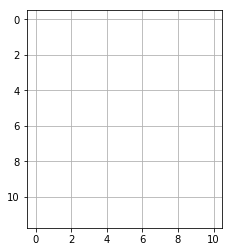

In [9]:
fig, ax = plt.subplots(1, 1)
camera = Camera(fig)

Q = trace_Q[0]
s = trace_s[0]
a = trace_a[0]

vis_map = np.max(Q, 2) * vis_filter
masked_array = np.ma.array(vis_map, mask=np.isnan(vis_map))

ax.imshow(masked_array, cmap=cmap, vmin=-10., vmax=10.)
ax.grid(True)
agent_glyph = plt.scatter(s[1], s[0], marker="o", color=[0.8, 0.8, 0.8], edgecolors='black')
camera.snap()
for i in range(1, len(trace_Q)):
    a = trace_a[i - 1]
    
    ax.imshow(masked_array, cmap=cmap, vmin=-10., vmax=10.)
    ax.grid(True)
    sa = s + actions[a, :]
    agent_glyph = plt.scatter(sa[1], sa[0], marker="o", color=[0.8, 0.8, 0.8], edgecolors='yellow')
    camera.snap()
    
    Q = trace_Q[i]
    s = trace_s[i]
    
    vis_map = np.max(Q, 2) * vis_filter
    masked_array = np.ma.array(vis_map, mask=np.isnan(vis_map))

    ax.imshow(masked_array, cmap=cmap, vmin=-10., vmax=10.)
    ax.grid(True)
    agent_glyph = plt.scatter(s[1], s[0], marker="o", color=[0.8, 0.8, 0.8], edgecolors='black')
    camera.snap()
animation = camera.animate()
plt.show()

In [10]:
HTML(animation.to_jshtml())

In [ ]:
for i in range(2, 1000):
    (num_steps, trace_Q, trace_s, trace_a) = qlearning_episode(False)
    print("Episode " + str(i) + " finished after " + str(num_steps) + " steps.")
(num_steps, trace_Q, trace_s, trace_a) = qlearning_episode(True)
print("Episode 1000 finished after " + str(num_steps) + " steps.")

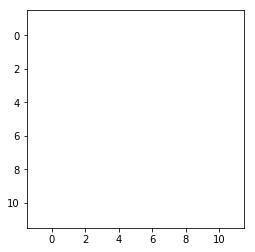

In [17]:
fig, ax = plt.subplots(1, 1)
camera = Camera(fig)

Q = trace_Q[0]
s = trace_s[0]
a = trace_a[0]

vis_map = np.max(Q, 2) * vis_filter
masked_array = np.ma.array(vis_map, mask=np.isnan(vis_map))

ax.imshow(masked_array, cmap=cmap, vmin=-10., vmax=10.)
ax.set_xlim((-1.5, grid.shape[0] + 0.5))
ax.set_ylim((grid.shape[1] + 0.5, -1.5))
ax.axis('off')
agent_glyph = plt.scatter(s[1], s[0], marker="o", color=[0.8, 0.8, 0.8], edgecolors='black')
camera.snap()
for i in range(1, len(trace_Q)):
    a = trace_a[i - 1]
    
    ax.imshow(masked_array, cmap=cmap, vmin=-10., vmax=10.)
    ax.set_xlim((-1.5, grid.shape[0] + 0.5))
    ax.set_ylim((grid.shape[1] + 0.5, -1.5))
    ax.axis('off')
    sa = s + actions[a, :]
    agent_glyph = plt.scatter(sa[1], sa[0], marker="o", color=[0.8, 0.8, 0.8], edgecolors='yellow')
    camera.snap()
    
    Q = trace_Q[i]
    s = trace_s[i]
    
    vis_map = np.max(Q, 2) * vis_filter
    masked_array = np.ma.array(vis_map, mask=np.isnan(vis_map))

    ax.imshow(masked_array, cmap=cmap, vmin=-10., vmax=10.)
    ax.set_xlim((-1.5, grid.shape[0] + 0.5))
    ax.set_ylim((grid.shape[1] + 0.5, -1.5))
    ax.axis('off')
    agent_glyph = plt.scatter(s[1], s[0], marker="o", color=[0.8, 0.8, 0.8], edgecolors='black')
    camera.snap()
animation = camera.animate()
plt.show()

In [18]:
HTML(animation.to_jshtml())